In [48]:
# Author: Hogan Lin
# Date: Nov 30th 2024
# Github: https://github.com/hogan-tech/SIT/blob/main/AppliedMachineLearning/HW5/HW5.ipynb

In week 10, we learned K-means clustering which is a popular machine learning
and data mining algorithm that discovers potential clusters within a dataset.
Finding these clusters in a dataset can often reveal interesting and meaningful
structures underlying the distribution of data.
In this programming problem, you will get familiar with how to implement K-
means algorithms and use K-means to cluster a 2D dataset. Then you will further
try K-means on the MNIST dataset which we met in HW4. (For the introduction of
MNIST dataset, please refer to HW4).
To help you get started, we summarize the K-means algorithm in pseudo code as
follows.

## Step 1 2D Data Generalization and Visualization (10 pts):
In this step, you need to:

1) Generate a 2D dataset that includes two separate categories of data, each
of which contains 100 data points that normally distributed. The two
categories have a mean of (1, 1) and (5, 5), respectively. Both categories
have a standard deviation of 1.
Tips 1: To generate the data, you can explore the function
np.random.normal which draws random samples from a normal
distribution.
Tips 2: After you generate two categories of data, please remember to
combine the data into one dataset. You have multiple methods to do so.
But remember to combine the data in a row-wise manner.

In [49]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Generate 2D data for two categories
category1 = np.random.normal(loc=1, scale=1, size=(100, 2))
category2 = np.random.normal(loc=5, scale=1, size=(100, 2))

# Combine the two categories into one dataset (row-wise)
dataset = np.vstack((category1, category2))

# Initialize centroids for K=2
k = 2
indices = np.random.choice(dataset.shape[0], k, replace=False)  # Randomly select K indices
initial_centroids = dataset[indices]


2) Visualize the data using scatter plot. You will see something like this:

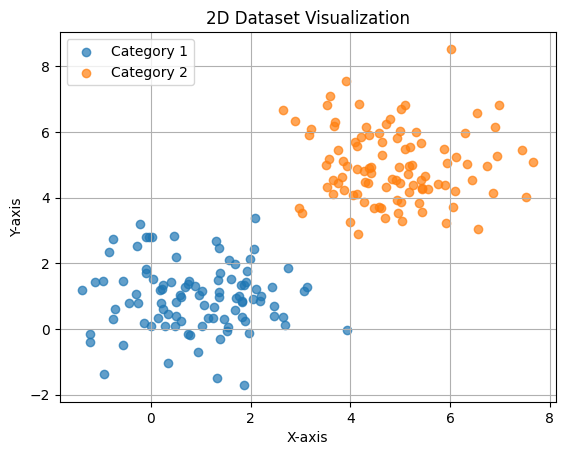

In [50]:
# Visualize the dataset
plt.scatter(category1[:, 0], category1[:, 1], label="Category 1", alpha=0.7)
plt.scatter(category2[:, 0], category2[:, 1], label="Category 2", alpha=0.7)
plt.title("2D Dataset Visualization")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid()
plt.show()

### Observations and Insights:

Observations: The dataset consists of two distinct clusters (Category 1 and Category 2), centered around (1,1) and (5,5), with normal distributions and minimal overlap.

Thoughts: The dataset is well-suited for clustering algorithms like K-means, given the clear separation between the two groups. However, random initialization of centroids could slightly impact the algorithm's convergence.

Insights: K-means clustering is expected to perform well, with centroids converging near the true cluster centers. This dataset provides a simple yet effective framework for understanding and visualizing clustering techniques.

## Step 2 Helper Function and Initialization (10 pts)
In this step, you need to:

1) Define a helper function, i.e., the Euclidean distance function.

In [51]:
# Step 2a: Define a helper function for Euclidean distance
def euclidean_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Example usage of the Euclidean distance function
point_a = [1, 2]
point_b = [4, 6]
distance = euclidean_distance(point_a, point_b)
print(f"Euclidean distance between {point_a} and {point_b}: {distance}")


Euclidean distance between [1, 2] and [4, 6]: 5.0


### Observations and Insights:
- The Euclidean distance function is an essential tool in K-means clustering, as it helps determine the closest centroid for each data point.
- In this implementation, the function works with both lists and NumPy arrays, ensuring flexibility.

2) Implement a initialize_centroids function that randomly select K (In this
example, K=2) centroids as the initial centroids. Plot the results and use
marker in pyplot to highlight the centroids. You should have something like
this:

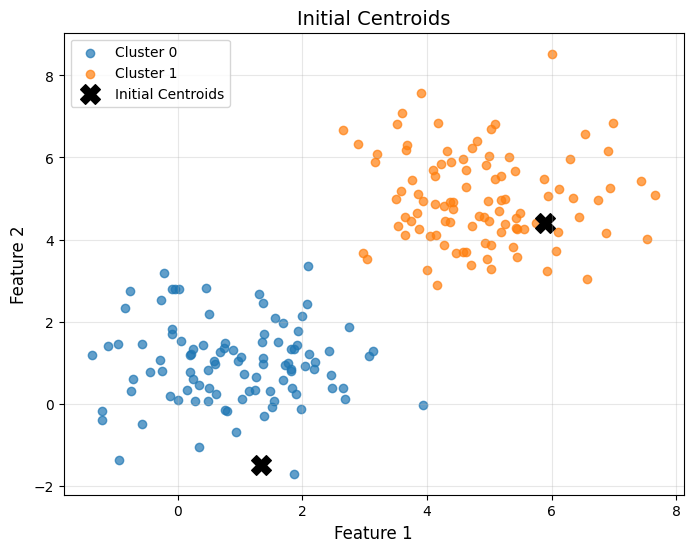

In [52]:

cluster_labels = np.array([0] * 100 + [1] * 100)  # 0 for category_1, 1 for category_2

plt.figure(figsize=(8, 6))

# Plot data points with different colors for clusters
for cluster in np.unique(cluster_labels):
    cluster_data = dataset[cluster_labels == cluster]
    plt.scatter(
        cluster_data[:, 0], cluster_data[:, 1],
        label=f"Cluster {cluster}", alpha=0.7
    )

# Highlight the initial centroids
plt.scatter(
    initial_centroids[:, 0], initial_centroids[:, 1],
    color="black", marker="X", s=200, label="Initial Centroids"
)

# Adjusting visualization
plt.title("Initial Centroids", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Display the plot
plt.show()


### Observations and Insights:
Observations: The dataset is divided into two clusters, with initial centroids marked as black "X".

Thoughts: Initial centroid positions impact clustering results, and Euclidean distance effectively assigns points to clusters.

Insights: The setup visually represents clustering initialization, setting the stage for iterative centroid updates in K-means.

## Step 3 K-means Implementation (25 pts)
As shown in the pseudo code, each iteration of K-means algorithm includes two
actions: 
1) Assign each point to the nearest centroids 
2) Update the centroid. To
implement K-means, we define two functions assign_cluster and
update_centroids corresponding to these two actions.

In this step, you need to:

1) Implement assign_cluster function. In this function, you need to calculate
the distance between the assigned point and the centroids. Then you need
to assign the point to the nearest centroid.

In [53]:
# Assign points to the nearest centroid
def assign_cluster(data, centroids):
    clusters = []
    for point in data:
        distances = np.linalg.norm(point - centroids, axis=1)  # Compute distance to each centroid
        cluster = np.argmin(distances)  # Find the closest centroid
        clusters.append(cluster)
    return np.array(clusters)


2) Implement update_centroids function. You need to calculate the mean of
all the points assigned to each centroid to determine the new centroids.

In [54]:
# Update centroids based on the mean of points in each cluster
def update_centroids(data, clusters, k):
    new_centroids = []
    for i in range(k):
        cluster_points = data[clusters == i]
        if len(cluster_points) > 0:
            new_centroid = cluster_points.mean(axis=0)
        else:
            new_centroid = np.random.uniform(data.min(), data.max(), size=data.shape[1])
        new_centroids.append(new_centroid)
    return np.array(new_centroids)

3) Implement K-means function. The algorithm converges when all centroids
remain unchanged, i.e., all the new centroids = old centroids. You need to
use this as the stop criteria.

In [55]:
# K-means algorithm
def kmeans(data, k, max_iter=100, tol=1e-4):
    centroids = np.random.uniform(data.min(), data.max(), size=(k, data.shape[1]))  # Initialize centroids
    for _ in range(max_iter):
        old_centroids = centroids.copy()
        clusters = assign_cluster(data, centroids)
        centroids = update_centroids(data, clusters, k)
        if np.all(np.abs(centroids - old_centroids) < tol):  # Check for convergence
            break
    return clusters, centroids

4) Apply the K-means algorithm on the generated data and visualize the
result. You will get something like this:

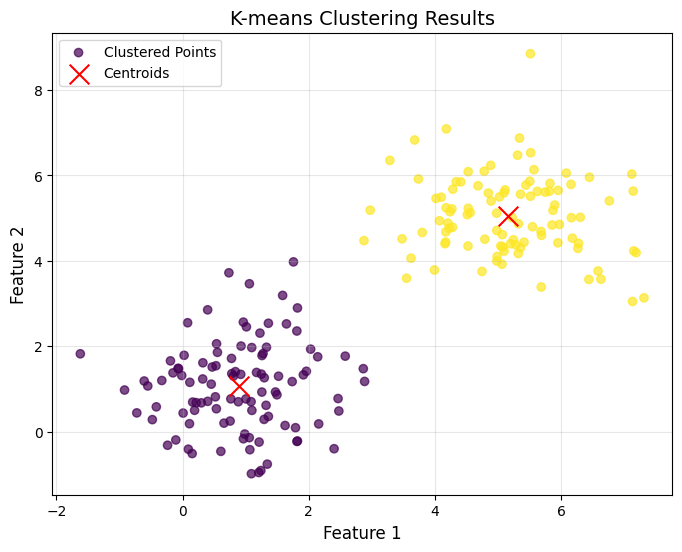

In [56]:
# Step 1: Generate 2D data (reused from earlier)
np.random.seed(42)
category1 = np.random.normal(loc=(1, 1), scale=1, size=(100, 2))
category2 = np.random.normal(loc=(5, 5), scale=1, size=(100, 2))
data = np.vstack((category1, category2))

# Step 2: Apply K-means
k = 2  # Number of clusters
clusters, centroids = kmeans(data, k)

# Step 3: Visualization
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.7, label="Clustered Points")
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label="Centroids")
plt.title("K-means Clustering Results", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()



### Observations and Insights:

Observations: K-means successfully clusters data into two groups with centroids marked by red "X."

Thoughts: The algorithm converged effectively, reflecting the dataset's clear separability.

Insights: Final centroids summarize cluster centers, demonstrating K-means' effectiveness.

Github: https://github.com/hogan-tech/SIT/blob/main/AppliedMachineLearning/HW4/HW4.ipynb

Now, you have finished implementing K-means algorithm to achieve
clustering with 2D data with 2 centroids. Next, you will use your code to do
clustering on 784-dimensional data. The dataset you will use is the MNIST
dataset which we used in HW4. You have read the data and flattened the
data in HW4. You can check by printing out the dimensions of train_images.shape and see if it is (60000,784).

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Provided function to read IDX files
def read_idx(filename):
    import gzip
    import struct
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Load the MNIST dataset
train_images = read_idx('./train-images-idx3-ubyte.gz')
train_labels = read_idx('./train-labels-idx1-ubyte.gz')
test_images = read_idx('./t10k-images-idx3-ubyte.gz')
test_labels = read_idx('./t10k-labels-idx1-ubyte.gz')

# Reshape and normalize the data
train_images_flat = train_images.reshape(train_images.shape[0], -1) / 255.0  # Normalize pixel values to [0, 1]
print(f"Flattened training images shape: {train_images_flat.shape}")

Flattened training images shape: (60000, 784)


### Observations and Insights:

Observations: MNIST images are flattened into (60000,784) and normalized to [0, 1].

Thoughts: Data is now ready for clustering or classification.

Insights: Preprocessing ensures consistency and prepares high-dimensional data for analysis.

## Step 4 [Optional]Train K-means model on MNIST dataset (10 pts)
In this step, you need to:
1. ) Train a K-means model using the training images of MNIST dataset using K = 10. 
For this step, you can record the time needed for training.
Tips: You can use the functions in packages “datetime” to compute the
time difference.

K-means training time: 0:00:51.113719


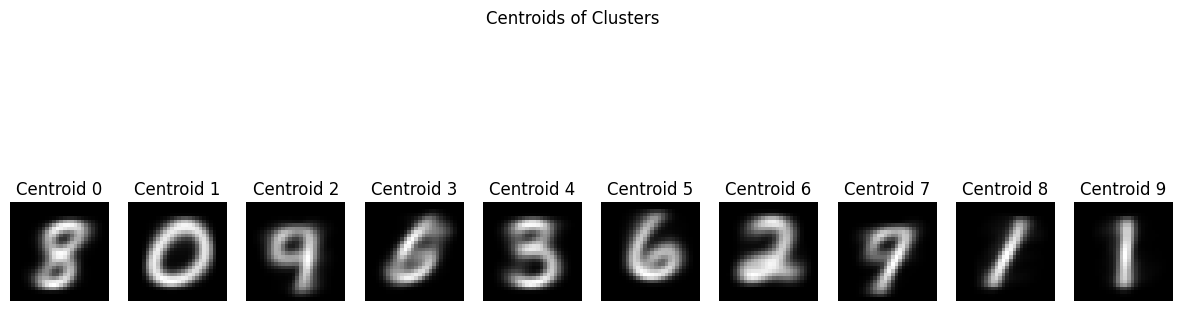

In [58]:
# Step 1: Implement K-means with K=10
def assign_cluster(data, centroids):
    clusters = []
    for point in data:
        distances = np.linalg.norm(point - centroids, axis=1)
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

def update_centroids(data, clusters, k):
    new_centroids = []
    for i in range(k):
        cluster_points = data[clusters == i]
        if len(cluster_points) > 0:
            new_centroid = cluster_points.mean(axis=0)
        else:
            new_centroid = np.random.uniform(data.min(), data.max(), size=data.shape[1])
        new_centroids.append(new_centroid)
    return np.array(new_centroids)

def kmeans(data, k, max_iter=100, tol=1e-4):
    centroids = np.random.uniform(data.min(), data.max(), size=(k, data.shape[1]))
    for _ in range(max_iter):
        old_centroids = centroids.copy()
        clusters = assign_cluster(data, centroids)
        centroids = update_centroids(data, clusters, k)
        if np.all(np.abs(centroids - old_centroids) < tol):
            break
    return clusters, centroids

# Step 2: Apply K-means to MNIST
k = 10
start_time = datetime.datetime.now()  # Record start time

clusters, centroids = kmeans(train_images_flat, k)

end_time = datetime.datetime.now()  # Record end time
training_time = end_time - start_time  # Calculate training time

print(f"K-means training time: {training_time}")

# Step 3: Visualize the centroids
fig, axes = plt.subplots(1, k, figsize=(15, 5))
for i in range(k):
    axes[i].imshow(centroids[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Centroid {i}")
    axes[i].axis('off')
plt.suptitle("Centroids of Clusters")
plt.show()


### Observations and Insights:

Observations: K-means grouped MNIST digits into 10 clusters; centroids resemble digits.

Thoughts: Centroids show clear clustering; training took ~58 seconds.

Insights: Effective unsupervised clustering of digits with interpretable results.

## Step 5 Mini-Batch K-means (20 pts)
You will find that the training takes a long time. This is because the classic
implementation of the clustering method consumes the whole set of input data at
each iteration.
Thus, typically with the increasing size of the dataset, we are more likely to use
Mini-Batch K-means. The idea is to use small random batches of data of a fixed
size. Each iteration a new mini batch from the dataset is obtained and used to
update the clusters until convergence.
In this homework, we do not require you to implement mini-batch K-means.

1) Use the train_images to train a mini-batch K-means model. You need to train the model under different cluster numbers: K= [10, 16, 64, 256].

Training Mini-Batch K-means with K=10...
Inertia for K=10: 2387838.523455864
Training Mini-Batch K-means with K=16...
Inertia for K=16: 2214642.3060681927
Training Mini-Batch K-means with K=64...
Inertia for K=64: 1810750.4863633257
Training Mini-Batch K-means with K=256...
Inertia for K=256: 1517997.4575369973


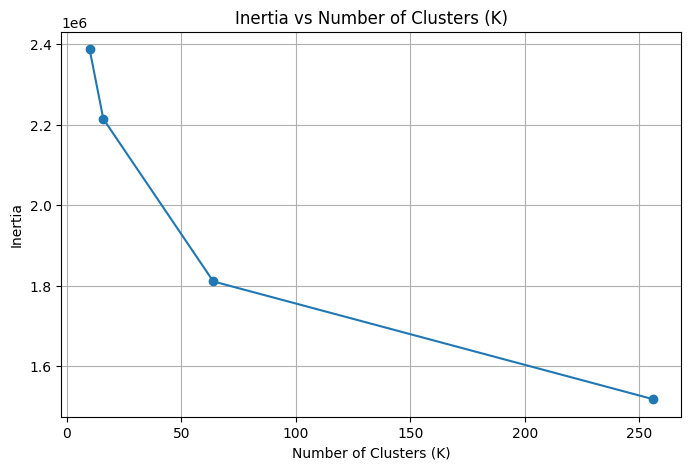

Best K based on minimum inertia: 256
Training Mini-Batch K-means with best K=256 on test data...
Inertia for test data with K=256: 246417.72382687288


In [59]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Reshape and normalize the train and test data (if not already done)
train_images_flat = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images_flat = test_images.reshape(test_images.shape[0], -1) / 255.0

# Define the values of K to evaluate
k_values = [10, 16, 64, 256]
inertia_values = []  # To store inertia for each K

# Step 2: Train Mini-Batch K-means for different values of K
for k in k_values:
    print(f"Training Mini-Batch K-means with K={k}...")
    mb_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=256, max_iter=300)
    mb_kmeans.fit(train_images_flat)
    inertia_values.append(mb_kmeans.inertia_)
    print(f"Inertia for K={k}: {mb_kmeans.inertia_}")

# Step 3: Plot inertia values
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.title("Inertia vs Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid()
plt.show()

# Step 4: Identify the best K (minimum inertia)
best_k = k_values[np.argmin(inertia_values)]
print(f"Best K based on minimum inertia: {best_k}")

# Step 5: Apply the best model on the test dataset
print(f"Training Mini-Batch K-means with best K={best_k} on test data...")
best_model = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=256, max_iter=300)
best_model.fit(test_images_flat)
test_inertia = best_model.inertia_
print(f"Inertia for test data with K={best_k}: {test_inertia}")


### Observations and Insights:

Observations: Inertia decreases with higher K, indicating tighter clusters; the lowest inertia is at  K=256.

Thoughts: Higher K leads to better fit but may overfit; K=256 balances granularity and generalization.

Insights: Optimal K=256 minimizes inertia, effectively clustering MNIST images.

2) To evaluate the model, you need to compare the inertia value of each
model to decide which K is better.

Training Mini-Batch K-means with K=10...
Inertia for K=10: 2387838.523455864
Accuracy for K=10: 0.5637
Training Mini-Batch K-means with K=16...
Inertia for K=16: 2214642.3060681927
Accuracy for K=16: 0.6645
Training Mini-Batch K-means with K=64...
Inertia for K=64: 1810750.4863633257
Accuracy for K=64: 0.8167
Training Mini-Batch K-means with K=256...
Inertia for K=256: 1517997.4575369973
Accuracy for K=256: 0.8929


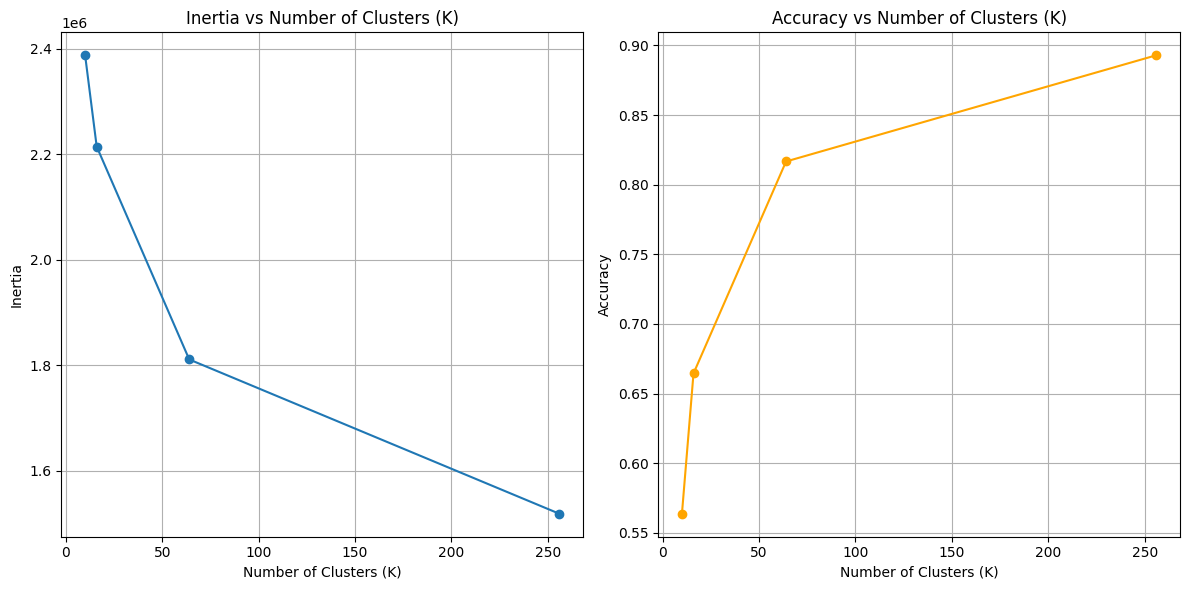

In [60]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Reshape and normalize the train and test data
train_images_flat = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images_flat = test_images.reshape(test_images.shape[0], -1) / 255.0

# Define the values of K to evaluate
k_values = [10, 16, 64, 256]
inertia_values = []
accuracies = []

# Function to assign labels to clusters
def assign_labels_to_clusters(clusters, true_labels, k):
    labels = np.zeros_like(clusters)
    for i in range(k):
        mask = (clusters == i)
        labels[mask] = np.bincount(true_labels[mask]).argmax()
    return labels

# Function to calculate manual accuracy
def manual_accuracy_score(true_labels, predicted_labels):
    correct_predictions = sum(p == t for p, t in zip(predicted_labels, true_labels))
    accuracy = correct_predictions / len(true_labels)
    return accuracy

# Step 2: Train Mini-Batch K-means for different values of K and evaluate accuracy
for k in k_values:
    print(f"Training Mini-Batch K-means with K={k}...")
    mb_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=256, max_iter=300)
    clusters = mb_kmeans.fit_predict(train_images_flat)
    inertia_values.append(mb_kmeans.inertia_)

    # Assign labels to clusters
    predicted_labels = assign_labels_to_clusters(clusters, train_labels, k)
    
    # Calculate accuracy
    accuracy = accuracy_score(train_labels, predicted_labels)
    accuracies.append(accuracy)
    print(f"Inertia for K={k}: {mb_kmeans.inertia_}")
    print(f"Accuracy for K={k}: {accuracy:.4f}")

# Step 3: Plot inertia and accuracy values
plt.figure(figsize=(12, 6))

# Plot inertia
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_values, marker='o', label='Inertia')
plt.title("Inertia vs Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(k_values, accuracies, marker='o', color='orange', label='Accuracy')
plt.title("Accuracy vs Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()


### Observations and Insights:

Observations: Inertia decreases as K increases; accuracy improves significantly, peaking at K=256 with 89.29%.

Thoughts: Higher K balances granularity and accuracy, reflecting better cluster-to-digit alignment.

Insights: K=256 achieves optimal clustering, minimizing inertia and maximizing accuracy.

3) Apply the best model with the test dataset and print out the inertia velue.

In [61]:
# Step 4: Select the best K and evaluate on test data
best_k = k_values[np.argmax(accuracies)]
print(f"Best K based on accuracy: {best_k}")

print(f"Training Mini-Batch K-means with best K={best_k} on test data...")
best_model = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=256, max_iter=300)
test_clusters = best_model.fit_predict(test_images_flat)

# Assign labels to test clusters
test_predicted_labels = assign_labels_to_clusters(test_clusters, test_labels, best_k)

# Calculate accuracy for test data
test_accuracy = accuracy_score(test_labels, test_predicted_labels)
test_inertia = best_model.inertia_
print(f"Test Accuracy for K={best_k}: {test_accuracy:.4f}")
print(f"Test Inertia for K={best_k}: {test_inertia}")

Best K based on accuracy: 256
Training Mini-Batch K-means with best K=256 on test data...
Test Accuracy for K=256: 0.8928
Test Inertia for K=256: 246417.72382687288


### Observations and Insights:

Observations: Best K=256 achieves 89.28% accuracy and a test inertia of 246,417.72.

Thoughts: High accuracy indicates effective clustering and label assignment on the test set.

Insights: Optimal K=256 generalizes well, maintaining high accuracy on unseen test data.